In [1]:
from lionagi.core.message import System, Instruction
from lionagi.core.execute.structure_executor import StructureExecutor
from lionagi.core.execute.instruction_map_executor import InstructionMapExecutor
from lionagi.core.agent.base_agent import BaseAgent

from lionagi.core.action import func_to_tool, DirectiveSelection

# Create Nodes

In [2]:
sys_mul = System("you are asked to perform as a function picker and parameter provider")
instruction = Instruction(
    "Think step by step, understand the following basic math question and provide parameters for function calling."
)

Instruction nodes can link to Tool nodes, specifing the tool or tools to be used in that step

In [3]:
def multiply(number1: float, number2: float):
    """
    Perform multiplication on two numbers.

    Args:
        number1: First number to multiply.
        number2: Second number to multiply.

    Returns:
        The product of number1 and number2.

    """
    return number1 * number2


tool_m = func_to_tool(multiply)

Each Instruction node can link to an ActionSelection node. The supported actions include `chat`, `followup`, or `ReAct`. If no action is attached, the default execution mode is set to `chat`.

In [4]:
action = DirectiveSelection(directive="direct", directive_kwargs={'reason': True, 'score':True})

# Create Structure

In [5]:
struct_mul = StructureExecutor()
struct_mul.add_node(sys_mul)
struct_mul.add_node(instruction)
struct_mul.add_node(tool_m[0])
struct_mul.add_node(action)
struct_mul.add_edge(sys_mul, instruction)
struct_mul.add_edge(instruction, tool_m[0])
struct_mul.add_edge(instruction, action)

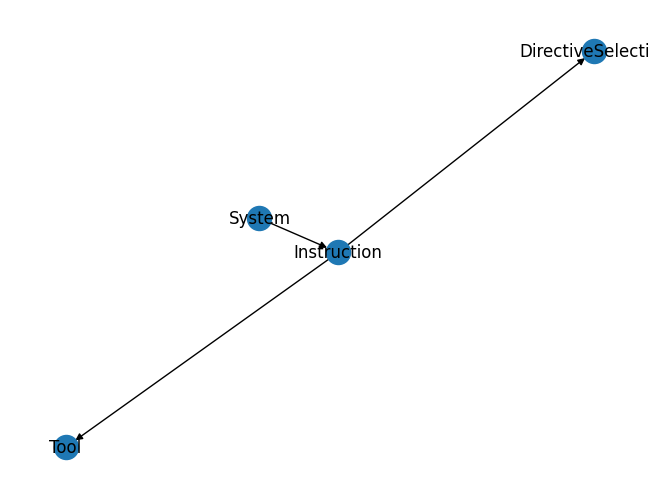

In [6]:
import networkx as nx
import matplotlib.pyplot as plt

g = struct_mul.to_networkx()
labels = nx.get_node_attributes(g, "class_name")
nx.draw(g, labels=labels)

In [7]:
# output_parser parameter: agent self
# output_parser return: the expected result that should be returned after execution
def output_parser(agent):
    ## return all message dataframe in all branches
    output = []
    for branch in agent.executable.branches.values():
        output.append(branch.to_df())
    return output


executable = InstructionMapExecutor()

In [8]:
calc = BaseAgent(
    structure=struct_mul,
    executable=executable,
    output_parser=output_parser,
)

# Usage

In [9]:
question1 = "A school is ordering laptops for its students. If each classroom has 25 students and the school wants to provide a laptop for each student in its 8 classrooms, how many laptops in total does the school need to order?"
question2 = "A bakery sells cupcakes in boxes of 6. If a customer wants to buy 8 boxes, with each person getting one cupcake, how many people can the customer serve cupcake to?"

import json

context = {"Question1": question1, "question2": question2}
context = json.dumps(context)

In [10]:
calc_result = await calc.execute(context)

------------------Welcome: system--------------------


system: you are asked to perform as a function picker and parameter provider

user: Think step by step, understand the following basic math question and provide parameters for function calling.

assistant a028bf0a3dee287196f4257dd1f6515d:


task: 
Follow the prompt and provide the necessary output.
- Additional instruction: Think step by step, understand the following basic math question and provide parameters for function calling.
- Additional context: {"Question1": "A school is ordering laptops for its students. If each classroom has 25 students and the school wants to provide a laptop for each student in its 8 classrooms, how many laptops in total does the school need to order?", "question2": "A bakery sells cupcakes in boxes of 6. If a customer wants to buy 8 boxes, with each person getting one cupcake, how many people can the customer serve cupcake to?"}
- Perform reasoning and prepare actions with GIVEN TOOLS ONLY.
- Perform scoring according to score range: [0, 10] and precision: integer.



reason: 
Let's think step by step, because we need to calculate the total number of laptops and the total number of cupcakes required.


actions: 
{'action_1': {'function': 'functions.multiply', 'arguments': {'number1': 25, 'number2': 8}}, 'action_2': {'function': 'functions.multiply', 'arguments': {'number1': 6, 'number2': 8}}}


action_required: 
True


answer: 
The school needs to order 200 laptops, and the customer can serve cupcakes to 48 people.


score: 
10


action_response: 
{'action_1': {'function': 'multiply', 'arguments': {'number1': 25, 'number2': 8}, 'output': 200}, 'action_2': {'function': 'multiply', 'arguments': {'number1': 6, 'number2': 8}, 'output': 48}}


action_performed: 
True


-----------------------------------------------------


In [11]:
calc_result[0]

,ln_id,message_type,timestamp,role,content,metadata,sender,recipient
0,2bd02ae0f8dd41378fa1b7ad83c3ec1d,System,2024-05-21T19:26:36.903240,system,{'system_info': 'you are asked to perform as a...,{'last_updated': {'recipient': '2024-05-21T19:...,system,a028bf0a3dee287196f4257dd1f6515d
1,0b57c266a73b81fafe115b72ecc78b0a,Instruction,2024-05-21T19:26:39.005069,user,{'instruction': ' 0. Your in is Follow the pro...,{'last_updated': {'sender': '2024-05-21T19:26:...,user,a028bf0a3dee287196f4257dd1f6515d
2,9c233cb2e14c50ab3ad64d0f08a21240,AssistantResponse,2024-05-21T19:26:43.182077,assistant,"{'assistant_response': '```json { ""answer"": ...",{'last_updated': {'sender': '2024-05-21T19:26:...,a028bf0a3dee287196f4257dd1f6515d,user
3,927fda4499669852acc184b1f210e463,ActionRequest,2024-05-21T19:26:43.183297,assistant,"{'action_request': {'function': 'multiply', 'a...",{'last_updated': {'function': '2024-05-21T19:2...,a028bf0a3dee287196f4257dd1f6515d,aab34a738036038ea63a4c2583989c4a
4,b14a40d1d3371db7deb0ee590913bca7,ActionRequest,2024-05-21T19:26:43.183423,assistant,"{'action_request': {'function': 'multiply', 'a...",{'last_updated': {'function': '2024-05-21T19:2...,a028bf0a3dee287196f4257dd1f6515d,aab34a738036038ea63a4c2583989c4a
5,da078668cd4d9939cd07526e441bc3f2,ActionResponse,2024-05-21T19:26:43.183668,assistant,"{'action_response': {'function': 'multiply', '...",{'last_updated': {'function': '2024-05-21T19:2...,aab34a738036038ea63a4c2583989c4a,a028bf0a3dee287196f4257dd1f6515d
6,2446f624988430c6c2a46a4cb182cdfa,ActionResponse,2024-05-21T19:26:43.183850,assistant,"{'action_response': {'function': 'multiply', '...",{'last_updated': {'function': '2024-05-21T19:2...,aab34a738036038ea63a4c2583989c4a,a028bf0a3dee287196f4257dd1f6515d
7,41b66e01073ccf9475e0ffe35a51b93f,Instruction,2024-05-21T19:26:43.184219,user,{'instruction': 'please provide final answer b...,{'last_updated': {'sender': '2024-05-21T19:26:...,user,a028bf0a3dee287196f4257dd1f6515d
8,1b67f7e85b92f329e0187e8a040934e9,AssistantResponse,2024-05-21T19:26:44.151656,assistant,"{'assistant_response': '{""answer"": ""The school...",{'last_updated': {'sender': '2024-05-21T19:26:...,a028bf0a3dee287196f4257dd1f6515d,user


# Storing Structures

We currently support the storage of structures in Excel and Neo4j, enabling their reuse in future applications.

### Excel

In [12]:
struct_mul.to_excel("tool_mul")  # dir = "structure_storage" (default)

### Neo4j

In [13]:
# initiate Neo4j Driver
uri = "bolt://localhost:7687"
user = "neo4j"
password = "12345678"
database = "neo4j"

from lionagi.integrations.storage.neo4j import Neo4j

neo4j = Neo4j(uri, user, password, database)

In [14]:
# structure_name is unique

await neo4j.store(struct_mul, structure_name="tool_mul")